In [18]:
import apogee.tools.read as apread
import matplotlib.pyplot as plt
import apogee.tools.path as apogee_path
from apogee.tools import bitmask

import random
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn

from torchcontrib.optim import SWA

from apoNN.src.datasets import ApogeeDataset

from tagging.src.networks import ConditioningAutoencoder,Embedding_Decoder,Feedforward,ParallelDecoder,Autoencoder

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
apogee_path.change_dr(16)

## Create dataset

In [19]:
allStar= apread.allStar(rmcommissioning=True,main=False,ak=True, akvers='targ',adddist=False)

upper_temp_cut = allStar["Teff"]<5000
lower_temp_cut = allStar["Teff"]>4000
lower_g_cut = allStar["logg"]>1.5
upper_g_cut = allStar["logg"]<3
snr_cut = allStar["SNR"]>100
snr_highcut = allStar["SNR"]<500
feh_outliercut = allStar["Fe_H"]>-5
o_outliercut = allStar["O_FE"]>-5
c_outliercut = allStar["C_FE"]>-5
na_outliercut = allStar["Na_FE"]>-5
mg_outliercut = allStar["Mg_FE"]>-5
si_outliercut = allStar["Si_FE"]>-5



combined_cut = lower_g_cut & upper_g_cut & lower_temp_cut & upper_temp_cut & snr_cut & snr_highcut & feh_outliercut & o_outliercut &  c_outliercut & na_outliercut & mg_outliercut & si_outliercut
cut_allStar = allStar[combined_cut]

/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/apogee/tools/read.py:303: RuntimeWarning: Extinction-corrected J,H,K not added because esutil is not installed
  warnings.warn("Extinction-corrected J,H,K not added because esutil is not installed",RuntimeWarning)


### Parameters


In [20]:
n_batch = 128
n_z = 80
n_bins = 8575
lr = 0.0001
n_datapoints = 10000

### Training

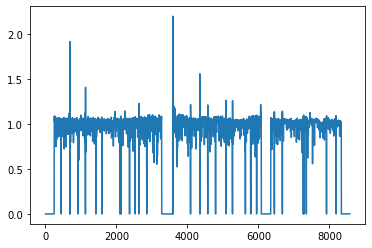

In [21]:
#dataset = ApogeeDataset(cut_allStar[:n_datapoints],outputs = ["apstar","physical","idx"])
#dataset = ApogeeDataset(cut_allStar[:n_datapoints],outputs = ["aspcap","physical","idx"])

dataset = ApogeeDataset(cut_allStar[:n_datapoints],outputs = ["apstar","aspcap","mask","physical","idx"])

loader = torch.utils.data.DataLoader(dataset = dataset,
                                     batch_size = n_batch,
                                     shuffle= False,
                                     drop_last=True)
plt.plot(dataset[0][0])

### Visualizing how the masks correlate with unknown features.

Some pixels are set to 0 and I want to understand if it is related to a mask

In [30]:
dataset = ApogeeDataset(cut_allStar[:n_datapoints],outputs = ["apstar","aspcap","mask","physical","idx"])

dataset.filtered_bits = [0,1,2,3,4,5,6,7,8]

Text(0.5, 1.0, 'illustration of bizare zero-ing out')

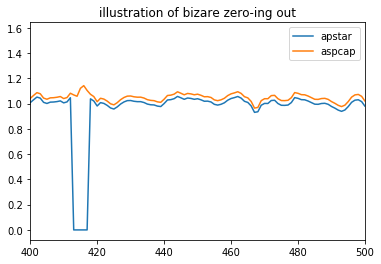

In [35]:
idx=51
#plt.plot(dataset[idx][2])
plt.plot(dataset[idx][1],label="apstar")
plt.plot(dataset[idx][0],label="aspcap")
plt.legend()


plt.xlim(400,500)
plt.title("illustration of bizare zero-ing out")

Text(0.5, 1.0, 'zeroing out moves. Suggests it might be redshift related')

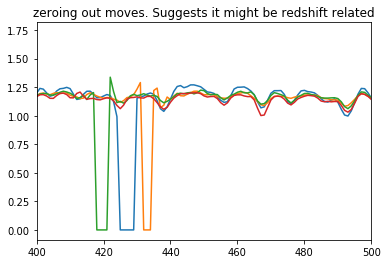

In [52]:
idx = 30
plt.plot(dataset[idx][1]/torch.mean(dataset[idx][1]).item())
plt.plot(dataset[idx+1][1]/torch.mean(dataset[idx+1][1]).item())
plt.plot(dataset[idx+2][1]/torch.mean(dataset[idx+2][1]).item())
plt.plot(dataset[idx+3][1]/torch.mean(dataset[idx+3][1]).item())


#plt.plot(dataset[idx+1][0])
#plt.plot(dataset[idx+2][0])
#plt.plot(dataset[idx+3][0])
#plt.plot(dataset[idx+4][0])

plt.xlim(400,500)
plt.title("zeroing out moves. Suggests it might be redshift related")

### Training of the neural network

In [26]:
encoder = Feedforward([n_bins,2048,512,n_z],activation=nn.SELU()).to(device)
decoder = Feedforward([n_z,512,2048,8192,n_bins],activation=nn.SELU()).to(device)

autoencoder = Autoencoder(encoder,decoder,n_bins=n_bins).to(device)
optimizer_autoencoder = torch.optim.Adam(autoencoder.parameters(), lr=lr)

we use swa in order to find better minima (or at leasat in theory)

In [ ]:
#autoencoder = torch.load("/share/splinter/ddm/taggingProject/apogeeFactory/outputs/pretrained/ae1")
optimizer_autoencoder = torch.optim.Adam(autoencoder.parameters(), lr=lr)
opt_swa = SWA(optimizer_autoencoder, swa_start=10, swa_freq=5, swa_lr=0.0001)

In [ ]:
loss = nn.L1Loss()

In [ ]:
for i in range(20000):
    for j,(x,u,idx) in enumerate(loader):
        opt_swa.zero_grad()
        x_pred,z = autoencoder(x.to(device))

        err_pred = loss(x_pred,x.to(device))

        err_tot = err_pred
        err_tot.backward()
        opt_swa.step()
        if j%100==0:
            print(f"err:{err_tot},err_pred:{err_pred}")


In [ ]:
opt_swa.swap_swa_sgd()

### Loading a model

We can also alternatively load a pretrained model

In [53]:
autoencoder = torch.load("/share/splinter/ddm/taggingProject/apogeeFactory/outputs/nn/ae/ae_l1/ae_200.p")


## Latent Visualization

In [ ]:
def get_z(idx,dataset):
    _,z = autoencoder(dataset[idx][0].to(device).unsqueeze(0))
    return z

def get_v(idx,dataset,feedforward):
    _,z = autoencoder(dataset[idx][0].to(device).unsqueeze(0))
    v = feedforward(z)
    return v

In [ ]:
z_array = np.array([get_z(i,dataset).detach().cpu().numpy() for i in range(n_datapoints)]).squeeze()
z_calibrated = (z_array- np.mean(z_array,axis=0)).T

In [ ]:
z_calibrated.shape

In [ ]:
abundances_array = np.array([cut_allStar["Teff"],cut_allStar["logg"],cut_allStar["Fe_H"],cut_allStar["O_FE"],cut_allStar["C_FE"],cut_allStar["Na_FE"],cut_allStar["Mg_FE"],cut_allStar["Si_FE"]])[:,:n_datapoints].T
abundances_array = (abundances_array-np.min(abundances_array,axis=0))/(np.max(abundances_array,axis=0)-np.min(abundances_array,axis=0)).T
abundances_calibrated = (abundances_array-np.mean(abundances_array,axis=0)).T

In [ ]:
W_est =np.dot(abundances_calibrated,np.linalg.pinv(z_calibrated))

In [ ]:
abundances_calibrated_est = np.dot(W_est,z_calibrated)


In [ ]:
idx = 0
plt.scatter(abundances_calibrated[idx],abundances_calibrated_est[idx],s=5,alpha=0.5)
plt.plot([-1,1],[-1,1],c="red")
plt.title("2900")
plt.ylim(-0.8,0.6)

In [ ]:
idx = 0
plt.scatter(abundances_calibrated[idx],abundances_calibrated_est[idx],s=5,alpha=0.5)
plt.plot([-1,1],[-1,1],c="red")
plt.title("2900")
plt.ylim(-0.8,0.6)

In [ ]:
plt.hist(abundances_calibrated[0],bins=100)

In [ ]:
plt.hist(abundances_calibrated_est[0],bins=100)

In [ ]:
plt.scatter(abundances_calibrated[0],abundances_calibrated_est[0],s=5,alpha=0.5)
plt.title("2900")
plt.ylim(-0.8,0.6)

In [ ]:
plt.scatter(abundances_calibrated_est[0],abundances_calibrated_est[1],s=5,alpha=0.5)
plt.ylim(-0.2,0.3)
plt.xlim(0,0.4)


In [ ]:
plt.scatter(abundances_calibrated[0],abundances_calibrated[1],s=5,alpha=0.5)


In [ ]:
plt.scatter(abundances_calibrated_est[0],abundances_calibrated_est[1],s=5,alpha=0.5,c=abundances_calibrated_est[2])


In [ ]:
plt.scatter(abundances_calibrated_est[0],abundances_calibrated_est[1],s=10,alpha=0.5,c=abundances_calibrated_est[2])
plt.ylim(0,0.4)
plt.xlim(-0.1,0.3)

In [ ]:
plt.hist(abundances_calibrated_est[0],bins=100)

In [ ]:
plt.scatter(abundances_calibrated[0],abundances_calibrated[1],s=10,alpha=0.5,c=abundances_calibrated_est[2])
#plt.ylim(0,0.4)
#plt.xlim(-0.1,0.3)

In [ ]:
plt.scatter(abundances_calibrated[0],abundances_calibrated[1],s=10,alpha=0.5,c=abundances_calibrated_est[2])
plt.ylim(0,0.5)
plt.xlim(-0.1,0.4)

## Non-linear better

### Setup

In [ ]:
feedforward = Feedforward([40,256,128,1],activation=nn.SELU()).to(device)
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(feedforward.parameters(),lr=0.0001)


In [ ]:
truth_tensor = torch.tensor(abundances_calibrated[7]).to(device)


In [ ]:
feedforwards = []
for idx_estimated in range(len(abundances_calibrated)):
    truth_tensor = torch.tensor(abundances_calibrated[idx_estimated]).to(device)
    
    feedforward = Feedforward([100,512,256,128,1],activation=nn.SELU()).to(device)
    loss = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(feedforward.parameters(),lr=0.0001)

    for i in range(5):
        for j,(x,u,idx) in enumerate(loader):
            optimizer.zero_grad()
            x_pred,z = autoencoder(x.to(device))
            pred = feedforward(z.detach())
            true = truth_tensor[idx]

            err = loss(pred,true.unsqueeze(1))    
            err.backward()
            optimizer.step()
            if j%100==0:
                print(f"epoch:{i},err:{err}")
                
    feedforwards.append(feedforward)


In [ ]:
abundances_non_linear = []
for feedforward in feedforwards:
    ab = np.array([get_v(i,dataset,feedforward).detach().cpu().numpy() for i in range(n_datapoints)]).squeeze()
    abundances_non_linear.append(ab)

In [ ]:
idx = 1
plt.scatter(abundances_calibrated[idx],abundances_non_linear[idx],s=5,alpha=0.5)
plt.plot([-1,1],[-1,1],c="red")

plt.title("2900")
plt.ylim(-0.8,0.6)
plt.xlim(-0.8,0.6)

In [ ]:
plt.scatter(abundances_non_linear[0],abundances_non_linear[1],s=5,alpha=0.5)


In [ ]:
plt.scatter(abundances_calibrated[0],abundances_calibrated[1],s=5,alpha=0.5)


In [ ]:
nonlinear_array.shape

In [ ]:
plt.scatter(abundances_calibrated[0],nonlinear_array,s=5,alpha=0.5)
plt.title("2900")
plt.ylim(-0.8,0.6)
plt.xlim(-0.8,0.6)

In [ ]:
import apogee.tools.read as apread
import matplotlib.pyplot as plt
import apogee.tools.path as apogee_path
from apogee.tools import bitmask

import random
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
   
    

In [ ]:
dataset = ApogeeDataset(cut_allStar)

In [3]:
s_xy= 1810.155
s_x= 235
s_y = 77.564
s_x2 = 5605
s_y2 = 603.60324
n=10

In [5]:
m = (n*s_xy-s_x*s_y)/(n*s_x2-s_x**2)
m

-0.15271515151514906

In [7]:
b = (s_y-m*s_x)/n
b

11.345206060606003

In [14]:
-0.1527*30+11.3452

6.7642

In [17]:
m*30+b

6.763751515151531

In [12]:
(6.2 -b )/m 

33.69152313675705

In [13]:
1990+33.69

2023.69

In [1]:
(1810.155-23.5*77.564-7.7564*235+23.5*7.7564*10)/(5605-2*23.5*235+23.5**2*10)

-0.15271515151515347

In [ ]:
print(*["a","b","c"])

In [ ]:
print("a","b","c")